<a href="https://colab.research.google.com/github/Adityxax/Video-Short-Boundary-Detection/blob/main/Marine_Predator_Algorithm(Complete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Upload Video File


In [ ]:
from google.colab import files

print("Please upload your video file :")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

print(f"Uploaded video: {video_path}")

Please upload your video file :


Saving SP Video (30 sec).mp4 to SP Video (30 sec).mp4
Uploaded video: SP Video (30 sec).mp4


###Extract Frames from Video


In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder="extracted_frames", frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Original video FPS: {fps:.2f}")

    if fps == 0:
        print("Error reading video FPS.")
        return []

    frame_interval = int(fps / frame_rate)
    count = 0
    saved_count = 0
    extracted_files = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_interval == 0:
            filename = os.path.join(output_folder, f"frame_{saved_count:04d}.png")
            cv2.imwrite(filename, frame)
            extracted_files.append(filename)
            saved_count += 1

        count += 1

    cap.release()
    print(f"Extracted {saved_count} frames at {frame_rate} FPS to folder '{output_folder}'.")
    return extracted_files

# Example usage
extracted_frames = extract_frames(video_path, frame_rate=30)  # Change frame rate here

Original video FPS: 30.00
Extracted 926 frames at 30 FPS to folder 'extracted_frames'.


###Convert Frames to Grayscale


In [ ]:
import cv2
import os

def convert_to_grayscale(input_folder="extracted_frames", output_folder="grayscale_frames"):
    if not os.path.exists(input_folder):
        print(f"Input folder '{input_folder}' does not exist.")
        return []
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_files = sorted(os.listdir(input_folder))
    grayscale_files = []

    for file in frame_files:
        input_path = os.path.join(input_folder, file)
        image = cv2.imread(input_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        output_path = os.path.join(output_folder, file)
        cv2.imwrite(output_path, gray)
        grayscale_files.append(output_path)

    print(f"Converted {len(grayscale_files)} frames to grayscale and saved to '{output_folder}'.")
    return grayscale_files

grayscale_frames = convert_to_grayscale(input_folder="extracted_frames", output_folder="grayscale_frames")

Converted 926 frames to grayscale and saved to 'grayscale_frames'.


###Feature Extraction from Grayscale Frames


Extracted features from 926 frames.
Frame file: grayscale_frames/frame_0000.png
Average intensity: 100.44


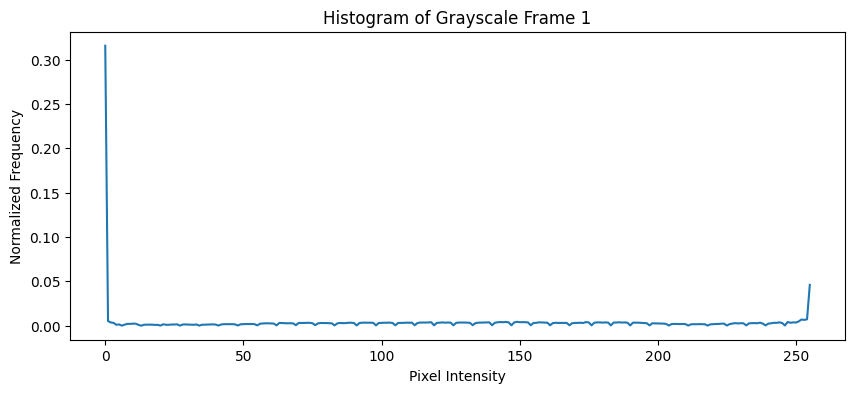

Frame file: grayscale_frames/frame_0001.png
Average intensity: 98.61


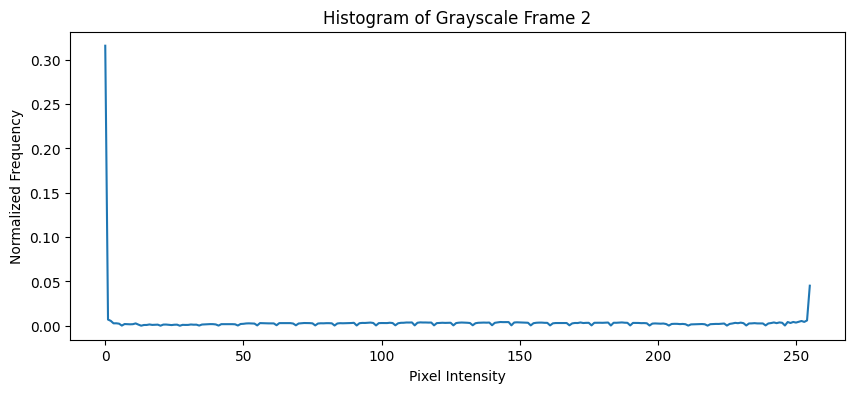

Frame file: grayscale_frames/frame_0002.png
Average intensity: 100.16


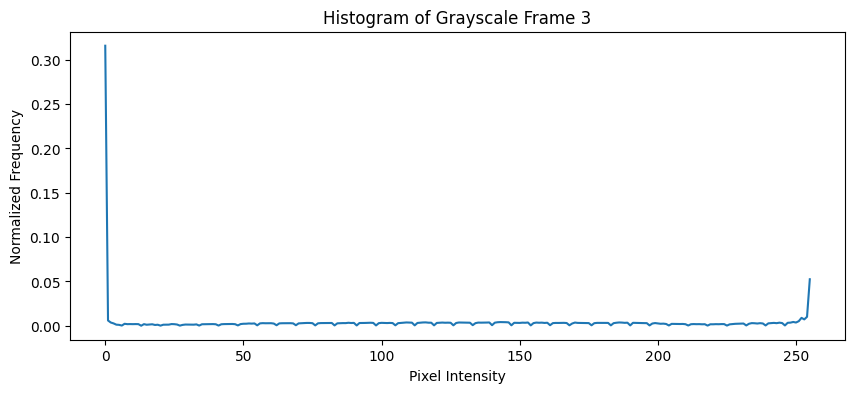

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_frame_features(frame_files):
    """
    Extract features such as average intensity and normalized histogram from grayscale frames.
    Returns a list of dictionaries containing features per frame.
    """
    features = []

    for frame_path in frame_files:
        gray_img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        avg_intensity = np.mean(gray_img)
        hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
        hist = hist.flatten() / np.sum(hist)  # Normalize histogram

        features.append({
            "frame_file": frame_path,
            "average_intensity": avg_intensity,
            "histogram": hist,
        })

    print(f"Extracted features from {len(features)} frames.")
    return features

# Example usage
features = extract_frame_features(grayscale_frames)

# Display features for first 3 frames
for i, feat in enumerate(features[:3]):
    print(f"Frame file: {feat['frame_file']}")
    print(f"Average intensity: {feat['average_intensity']:.2f}")
    plt.figure(figsize=(10,4))
    plt.plot(feat["histogram"])
    plt.title(f"Histogram of Grayscale Frame {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.show()

###Install Required Libraries


In [ ]:
!pip install opencv-python-headless tensorflow

Prepare Grayscale Images for CNN (Stack to 3-channels)


In [ ]:
import os
import cv2
import numpy as np

input_folder = "grayscale_frames"
frame_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".png") or f.endswith(".jpg")])

def convert_grayscale_to_rgb(frame_files, output_folder="grayscale_rgb_frames"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    rgb_files = []
    for fpath in frame_files:
        gray = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        rgb_img = cv2.merge([gray, gray, gray])
        out_path = os.path.join(output_folder, os.path.basename(fpath))
        cv2.imwrite(out_path, rgb_img)
        rgb_files.append(out_path)
    print(f"Converted {len(rgb_files)} grayscale images to RGB format for CNN input.")
    return rgb_files

rgb_frame_files = convert_grayscale_to_rgb(frame_files)

Converted 926 grayscale images to RGB format for CNN input.


### Extract CNN Features from Grayscale (3-Channel) Images using ResNet50


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')  # Outputs 2048-dim features

def extract_cnn_features_from_rgb_frames(frame_files, target_size=(224, 224)):
    features = []
    for fpath in frame_files:
        img = image.load_img(fpath, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat_vec = model.predict(x)
        features.append(feat_vec.flatten())
    features = np.array(features)
    print(f"Extracted CNN features from {len(features)} frames. Each vector size: {features.shape[1]}")
    return features

cnn_features = extract_cnn_features_from_rgb_frames(rgb_frame_files)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━

###Load CNN Features and Frame Filenames


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

# The cnn_features are already computed in the previous cell U7_iHZyua04Y
# No need to read from a CSV.

# Ensure 'extracted_frames' directory exists and is populated
if not os.path.exists("extracted_frames") or len(os.listdir("extracted_frames")) == 0:
    print("Re-extracting frames as 'extracted_frames' directory is missing or empty.")
    # This assumes video_path is available from a prior cell
    extracted_frames = extract_frames(video_path, frame_rate=30)

# Ensure 'grayscale_frames' directory exists and is populated
# The 'convert_to_grayscale' function needs 'extracted_frames' which should now be present
if not os.path.exists("grayscale_frames") or len(os.listdir("grayscale_frames")) == 0:
    print("Re-converting frames to grayscale as 'grayscale_frames' directory is missing or empty.")
    # Re-obtain the list of original extracted frames in case the variable was cleared
    extracted_frame_files = sorted([os.path.join("extracted_frames", f) for f in os.listdir("extracted_frames") if f.endswith('.png') or f.endswith('.jpg')])
    grayscale_frames = convert_to_grayscale(input_folder="extracted_frames", output_folder="grayscale_frames")
else:
    # If directory exists and is not empty, just load the list of files
    grayscale_frames = sorted([os.path.join("grayscale_frames", f) for f in os.listdir("grayscale_frames") if f.endswith('.png') or f.endswith('.jpg')])

frame_files = grayscale_frames

# Assert is still valid to check consistency after re-creation
assert len(frame_files) == cnn_features.shape[0], "Mismatch between number of frames and features!"

### Compute Feature Differences Between Consecutive Frames


In [ ]:
distances = np.linalg.norm(np.diff(cnn_features, axis=0), axis=1)
print(f"Calculated feature distances for {len(distances)} frame pairs.")

Calculated feature distances for 925 frame pairs.


### Define Simplified Marine Predator Algorithm


In [ ]:
class SimpleMPA:
    def __init__(self, obj_func, dim, n_predators=15, max_iter=35, lb=0.0, ub=1.0):
        self.obj_func = obj_func
        self.dim = dim
        self.n_predators = n_predators
        self.max_iter = max_iter
        self.lb = lb
        self.ub = ub

    def optimize(self):
        pop = np.random.uniform(self.lb, self.ub, (self.n_predators, self.dim))
        fit = np.array([self.obj_func(ind) for ind in pop])
        best_idx = np.argmin(fit)
        best = pop[best_idx]
        best_fit = fit[best_idx]

        for it in range(self.max_iter):
            for i in range(self.n_predators):
                perturb = np.random.normal(0, 0.06, self.dim)
                new = np.clip(pop[i] + perturb, self.lb, self.ub)
                new_fit = self.obj_func(new)
                if new_fit < fit[i]:
                    pop[i] = new
                    fit[i] = new_fit
                    if new_fit < best_fit:
                        best = new
                        best_fit = new_fit
            if it % 5 == 0 or it == self.max_iter-1:
                print(f"MPA iteration {it}: Best fitness = {best_fit:.4f}")
        return best, best_fit

###Objective Function for MPA Threshold Optimization


In [ ]:
def threshold_objective(th_params):
    threshold = th_params[0]
    # Basic method: Number of boundaries (high difference above threshold)
    transitions = (distances >= threshold).astype(int)
    # Penalize too many or too few transitions
    penalty = abs(transitions.sum() - (len(distances)*0.1))  # Expect ~10% transitions; adjust as needed
    return penalty + 0.1 * threshold   # Weighted objective

###Run MPA Optimization for Best Threshold


In [ ]:
dist_min = float(np.min(distances))
dist_max = float(np.max(distances))

mpa = SimpleMPA(threshold_objective, dim=1, n_predators=12, max_iter=25, lb=dist_min, ub=dist_max)
best_threshold, best_score = mpa.optimize()
best_threshold = best_threshold[0]
print(f">> Selected transition threshold by MPA: {best_threshold:.4f}")

MPA iteration 0: Best fitness = 46.2502
MPA iteration 5: Best fitness = 34.2678
MPA iteration 10: Best fitness = 20.2781
MPA iteration 15: Best fitness = 19.2798
MPA iteration 20: Best fitness = 5.2979
MPA iteration 24: Best fitness = 5.2979
>> Selected transition threshold by MPA: 7.9788


###Separate and Save Transition & Non-Transition Frames

In [ ]:
trans_labels = (distances >= best_threshold).astype(int)

os.makedirs("transition_frames", exist_ok=True)
os.makedirs("non_transition_frames", exist_ok=True)

for i in range(len(distances)):
    src = frame_files[i+1]  # i+1 because diff reduces length by 1
    if trans_labels[i] == 1:
        target = os.path.join("transition_frames", os.path.basename(src))
    else:
        target = os.path.join("non_transition_frames", os.path.basename(src))
    img = cv2.imread(src)
    cv2.imwrite(target, img)

print(f"Frames classified and saved to 'transition_frames' and 'non_transition_frames' directories.")

Frames classified and saved to 'transition_frames' and 'non_transition_frames' directories.


### Visualize Frame Distance and Transitions


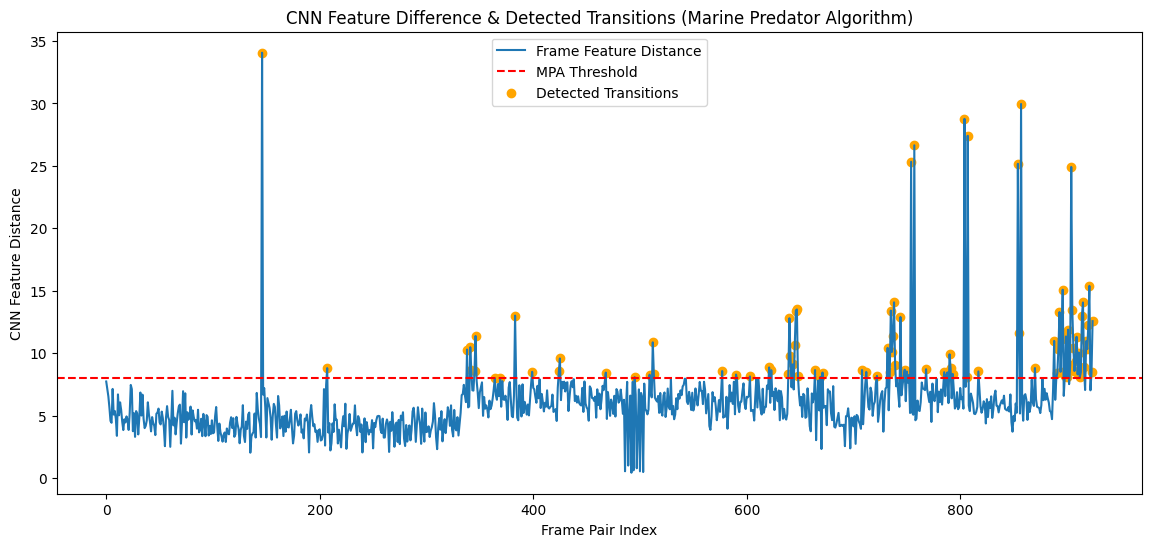

In [ ]:

plt.figure(figsize=(14,6))
plt.plot(distances, label="Frame Feature Distance")
plt.axhline(best_threshold, color='r', linestyle='--', label="MPA Threshold")
plt.scatter(np.where(trans_labels==1), distances[trans_labels==1], color='orange', label="Detected Transitions")
plt.xlabel("Frame Pair Index")
plt.ylabel("CNN Feature Distance")
plt.title("CNN Feature Difference & Detected Transitions (Marine Predator Algorithm)")
plt.legend()
plt.show()

###Collect CNN features for transition frames


In [ ]:
import os

# Get the list of files in the transition_frames directory
transition_files = sorted([os.path.join("transition_frames", f) for f in os.listdir("transition_frames") if f.endswith(".png") or f.endswith(".jpg")])

# Map frame_files to indices for transition_files by comparing just the filenames
transition_feature_indices = [i for i, f in enumerate(frame_files) if os.path.basename(f) in [os.path.basename(tf) for tf in transition_files]]
transition_features = cnn_features[transition_feature_indices]

print(f"Shape of CNN features for transition frames: {transition_features.shape}") # (count, 2048)

Shape of CNN features for transition frames: (97, 2048)


###Compute continuity matrix among transition frames


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

continuity_matrix = cosine_similarity(transition_features)

print("Continuity matrix shape:", continuity_matrix.shape)

# Save for further use
import pandas as pd
pd.DataFrame(continuity_matrix).to_csv('transition_continuity_matrix.csv', index=False)

Continuity matrix shape: (97, 97)


###Visualize the continuity matrix


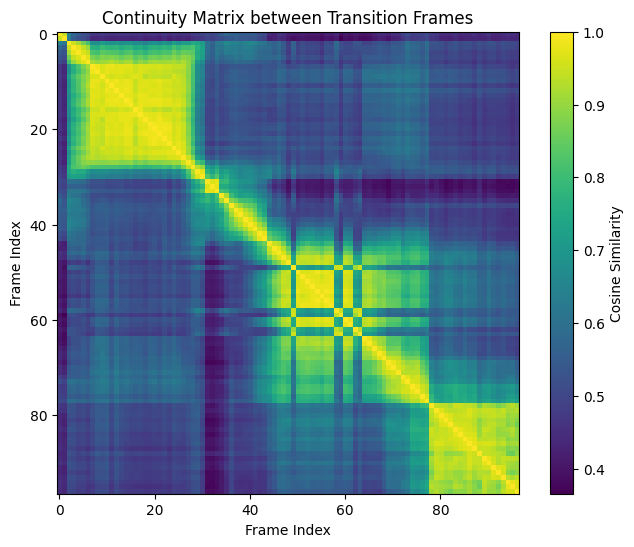

In [ ]:

plt.figure(figsize=(8,6))
plt.imshow(continuity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Cosine Similarity")
plt.title("Continuity Matrix between Transition Frames")
plt.xlabel("Frame Index")
plt.ylabel("Frame Index")
plt.show()

###Compute Adaptive Threshold using Otsu's method

In [ ]:

from skimage.filters import threshold_otsu

# Get off-diagonal values (since diagonal is always 1.0)
def off_diagonal_vals(mat):
    n = mat.shape[0]
    return [mat[i, j] for i in range(n) for j in range(n) if i != j]

off_diags = np.array(off_diagonal_vals(continuity_matrix))
adaptive_threshold = threshold_otsu(off_diags)
print(f"Adaptive threshold (Otsu): {adaptive_threshold:.4f}")

Adaptive threshold (Otsu): 0.7018


###Classify transitions and separate abrupt/gradual

In [ ]:
abrupt_indices = []
gradual_indices = []

# Only consider immediate neighboring pairs (i, i+1) for transitions
for i in range(continuity_matrix.shape[0]-1):
    sim = continuity_matrix[i, i+1]
    if sim < adaptive_threshold:
        abrupt_indices.append((i, i+1))
    else:
        gradual_indices.append((i, i+1))

print(f"Abrupt transitions found: {len(abrupt_indices)}")
print(f"Gradual transitions found: {len(gradual_indices)}")

Abrupt transitions found: 1
Gradual transitions found: 95


###Save abrupt/gradual transitions to folders

In [ ]:


import os
import cv2

os.makedirs('abrupt_transitions', exist_ok=True)
os.makedirs('gradual_transitions', exist_ok=True)

def save_transition_pairs(indices, src_files, dst_folder):
    for (i, j) in indices:
        for idx in [i, j]:
            fname = os.path.basename(src_files[idx])
            img = cv2.imread(src_files[idx])
            cv2.imwrite(os.path.join(dst_folder, f"{i:03d}_{fname}"), img)

save_transition_pairs(abrupt_indices, transition_files, 'abrupt_transitions')
save_transition_pairs(gradual_indices, transition_files, 'gradual_transitions')

print("Frame pairs for abrupt and gradual transitions saved.")

Frame pairs for abrupt and gradual transitions saved.


Displaying samples from 'abrupt_transitions':
  Segment 'direct_files': Total files = 2, Requested samples = 2
  Actual samples to display = 2


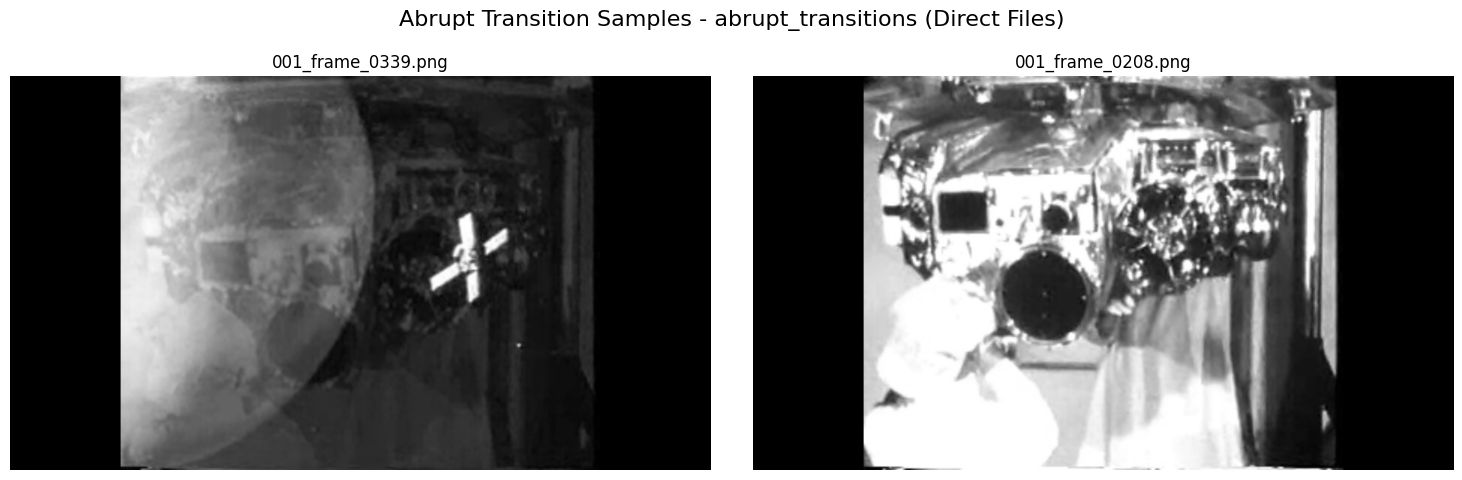

Displaying samples from 'gradual_transitions':
  Segment 'direct_files': Total files = 190, Requested samples = 6
  Actual samples to display = 6


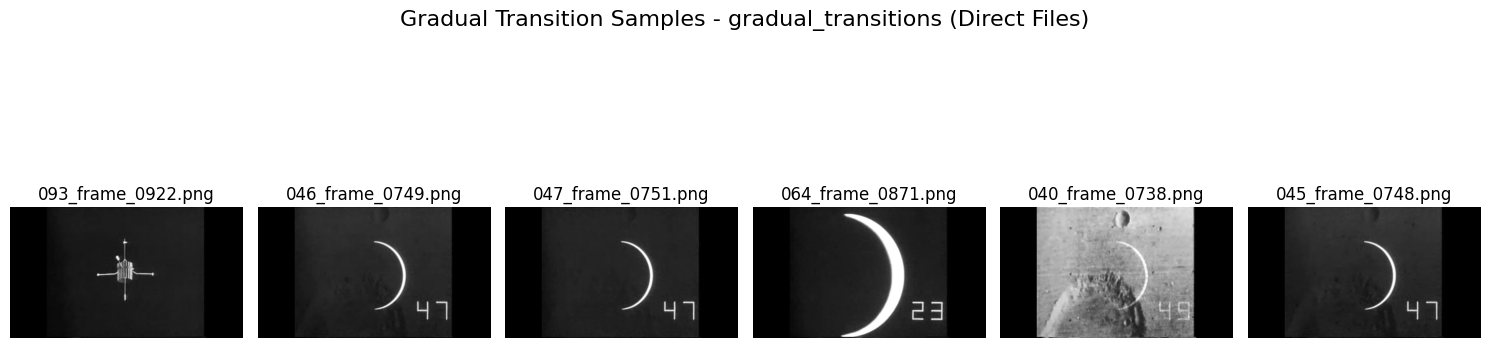

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import random

def display_sample_frames(root_folder, title, num_samples_per_segment=5):
    """Displays a random sample of images from each segment folder within the given root folder."""
    print(f"Displaying samples from '{root_folder}':")

    # Check if the root_folder itself contains image files directly
    direct_image_files = [f for f in os.listdir(root_folder) if os.path.isfile(os.path.join(root_folder, f)) and (f.endswith('.png') or f.endswith('.jpg'))]

    if direct_image_files:
        # If images are directly in the root, treat root as a single segment
        segment_paths_to_process = [(root_folder, 'direct_files')]
    else:
        # Otherwise, look for subfolders as segments
        segment_paths_to_process = [(os.path.join(root_folder, d), d) for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
        segment_paths_to_process.sort(key=lambda x: x[1]) # Sort by segment name

    if not segment_paths_to_process:
        print(f"No image files or segment folders found in '{root_folder}'.")
        return

    for segment_path, segment_name_display in segment_paths_to_process:
        if segment_name_display == 'direct_files':
            frame_files = [os.path.join(segment_path, f) for f in direct_image_files]
            segment_display_title = f"{title} - {os.path.basename(segment_path)} (Direct Files)"
        else:
            frame_files = [os.path.join(segment_path, f) for f in os.listdir(segment_path) if f.endswith('.png') or f.endswith('.jpg')]
            segment_display_title = f"{title} - {segment_name_display}"

        if not frame_files:
            print(f"No images found in segment '{segment_name_display}'.")
            continue

        print(f"  Segment '{segment_name_display}': Total files = {len(frame_files)}, Requested samples = {num_samples_per_segment}")
        sample_files = random.sample(frame_files, min(num_samples_per_segment, len(frame_files)))
        print(f"  Actual samples to display = {len(sample_files)}")

        plt.figure(figsize=(15, 5))
        plt.suptitle(segment_display_title, fontsize=16)
        for i, frame_path in enumerate(sample_files):
            img = cv2.imread(frame_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
                plt.subplot(1, num_samples_per_segment, i + 1)
                plt.imshow(img)
                plt.title(os.path.basename(frame_path))
                plt.axis('off')
            else:
                print(f"Warning: Could not read image {frame_path}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

display_sample_frames('abrupt_transitions', 'Abrupt Transition Samples', num_samples_per_segment=2)
display_sample_frames('gradual_transitions', 'Gradual Transition Samples', num_samples_per_segment=6)

## Get Total Frame Count

In [ ]:
total_frame_count = len(frame_files)
print(f"Total number of extracted frames: {total_frame_count}")

Total number of extracted frames: 926


###Abrupt indices


In [ ]:
total_abrupt_transitions = len(abrupt_indices)
print(f"Total number of abrupt transitions (cut frames): {total_abrupt_transitions}")

original_abrupt_frame_numbers = []
for i, j in abrupt_indices:
    # Get the filename from transition_files for index i and j
    frame_i_path = transition_files[i]
    frame_j_path = transition_files[j]

    # Extract the original frame number from the filename (e.g., 'frame_0147.png' -> 147)
    frame_i_num = int(os.path.basename(frame_i_path).replace('frame_', '').replace('.png', ''))
    frame_j_num = int(os.path.basename(frame_j_path).replace('frame_', '').replace('.png', ''))

    original_abrupt_frame_numbers.append((frame_i_num, frame_j_num))

print(f"Original frame numbers involved in abrupt transitions: {original_abrupt_frame_numbers}")

Total number of abrupt transitions (cut frames): 1
Original frame numbers involved in abrupt transitions: [(208, 339)]


###Gradual Indices

In [ ]:
total_gradual_transitions = len(gradual_indices)
print(f"Total number of gradual transitions: {total_gradual_transitions}")

original_gradual_frame_numbers = []
for i, j in gradual_indices:
    # Get the filename from transition_files for index i and j
    frame_i_path = transition_files[i]
    frame_j_path = transition_files[j]

    # Extract the original frame number from the filename (e.g., 'frame_0147.png' -> 147)
    frame_i_num = int(os.path.basename(frame_i_path).replace('frame_', '').replace('.png', ''))
    frame_j_num = int(os.path.basename(frame_j_path).replace('frame_', '').replace('.png', ''))

    original_gradual_frame_numbers.append((frame_i_num, frame_j_num))

print(f"Original frame numbers involved in gradual transitions: {original_gradual_frame_numbers}")

Total number of gradual transitions: 95
Original frame numbers involved in gradual transitions: [(147, 208), (339, 342), (342, 343), (343, 346), (346, 347), (347, 365), (365, 370), (370, 384), (384, 400), (400, 425), (425, 426), (426, 469), (469, 496), (496, 510), (510, 513), (513, 514), (514, 578), (578, 591), (591, 604), (604, 622), (622, 624), (624, 640), (640, 641), (641, 642), (642, 644), (644, 646), (646, 647), (647, 648), (648, 649), (649, 665), (665, 670), (670, 672), (672, 709), (709, 713), (713, 723), (723, 733), (733, 735), (735, 736), (736, 737), (737, 738), (738, 739), (739, 740), (740, 745), (745, 748), (748, 749), (749, 751), (751, 753), (753, 755), (755, 758), (758, 769), (769, 786), (786, 788), (788, 789), (789, 791), (791, 792), (792, 794), (794, 805), (805, 807), (807, 808), (808, 818), (818, 855), (855, 856), (856, 858), (858, 871), (871, 889), (889, 892), (892, 893), (893, 894), (894, 895), (895, 896), (896, 897), (897, 899), (899, 900), (900, 901), (901, 902), (90